In [6]:
import os
import glob
import numpy as np
import pandas as pd
import torch
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder, StandardScaler
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

class SMARTDataset(Dataset):
    """
    PyTorch custom Dataset for SMART data.
    
    This dataset reads SMART attribute CSV files, filters and groups the data by drive,
    and generates sequences of SMART attributes from each drive (identified by serial number).
    A candidate sequence is a sliding window (of length sequence_length) ending at a given date.
    A candidate is accepted only if it has less than 25% missing SMART values and its sequential label 
    (per drive) is <= days_before_failure. Sequences are generated on-demand in __getitem__.
    
    Additionally, you can restrict the dataset to a set of drive serial numbers using the
    'drives_to_include' parameter. This is useful for ensuring that drives in the training set
    do not appear in the test set (and vice versa).
    
    Args:
        data_directory (str): Path to the directory of SMART CSV data files.
        models_to_include (list, optional): List of encoded model identifiers to include.
        drives_to_include (list, optional): List of drive serial numbers to include. If None, all drives are used.
        days_before_failure (int, default=30): Maximum allowed sequence label for a drive.
            Only sequences with labels ≤ days_before_failure will be included.
        sequence_length (int, default=10): Number of consecutive days in each sequence.
        smart_attribute_numbers (list, default=[5, 187, 197, 198]): SMART attribute numbers.
        include_raw (bool, default=True): Include raw SMART values.
        include_normalized (bool, default=True): Include normalized SMART values.
        scaler (StandardScaler, optional): Pre-fitted scaler; if None, one is fitted from candidate sequences.
        model_label_encoder (LabelEncoder, optional): Pre-fitted encoder for drive models.
    """
    def __init__(
        self,
        data_directory,
        models_to_include=None,
        drives_to_include=None,
        days_before_failure=30,
        sequence_length=10,
        smart_attribute_numbers=[5, 187, 197, 198],
        include_raw=True,
        include_normalized=True,
        scaler=None,  
        model_label_encoder=None,
    ):
        self.data_directory = data_directory
        self.models_to_include = models_to_include
        self.drives_to_include = drives_to_include  # New parameter: restrict to these drive serial numbers
        self.days_before_failure = days_before_failure  # Used as max sequence label per drive
        self.sequence_length = sequence_length
        self.smart_attribute_numbers = smart_attribute_numbers
        self.include_raw = include_raw
        self.include_normalized = include_normalized
        self.scaler = scaler  
        self.model_label_encoder = model_label_encoder

        # Define SMART attribute column names
        self.smart_attributes = []
        for num in self.smart_attribute_numbers:
            if self.include_raw:
                self.smart_attributes.append(f'smart_{num}_raw')
            if self.include_normalized:
                self.smart_attributes.append(f'smart_{num}_normalized')
        
        # Dictionaries to hold raw drive data and index mapping
        self.drive_data = {}          # Key: serial_number, Value: drive DataFrame (filtered & sorted)
        self.index_mapping = []       # List of tuples: (serial_number, end_date, sequence_label)
        
        self.process_data()

    def process_data(self):
        # --- Step 1. Read CSV files and build failure_date_dict ---
        all_files = glob.glob(os.path.join(self.data_directory, '*.csv'))
        all_files.sort()
        print(f"Found {len(all_files)} CSV files in '{self.data_directory}'.")
        
        failure_date_dict = {}
        for filename in all_files:
            try:
                df = pd.read_csv(filename, usecols=['date', 'serial_number', 'failure'])
            except Exception as e:
                print(f"Error reading {filename}: {e}")
                continue
            df['date'] = pd.to_datetime(df['date'], errors='coerce')
            df['failure'] = pd.to_numeric(df['failure'], errors='coerce')
            failures = df[df['failure'] == 1]
            if not failures.empty:
                for _, row in failures.iterrows():
                    serial_number = row['serial_number']
                    failure_date = row['date']
                    failure_date_dict[serial_number] = failure_date

        print(f"Number of drives with failure events: {len(failure_date_dict)}")
        if len(failure_date_dict) == 0:
            print("Warning: No drives with failure events found. Check the 'failure' column values.")
        
        # --- Step 2. Collect data for failed drives ---
        failed_drives_data = defaultdict(list)
        cols = ['date', 'serial_number', 'model'] + self.smart_attributes + ['failure']
        for filename in all_files:
            try:
                df = pd.read_csv(filename, usecols=cols)
            except Exception as e:
                print(f"Error reading {filename}: {e}")
                continue
            df['date'] = pd.to_datetime(df['date'], errors='coerce')
            df_failed = df[df['serial_number'].isin(failure_date_dict.keys())]
            if df_failed.empty:
                continue
            for serial_number, group in df_failed.groupby('serial_number'):
                failed_drives_data[serial_number].append(group)
        
        # --- Step 3. Filter drive data based on minimum unique dates ---
        filtered_data_list = []
        min_unique_days = max(1, 3 * self.days_before_failure // 4)
        print(f"Minimum unique dates required per drive: {min_unique_days}")
        
        for serial_number, data_list in failed_drives_data.items():
            drive_data = pd.concat(data_list, ignore_index=True)
            failure_date = failure_date_dict[serial_number].normalize()
            drive_data['date'] = drive_data['date'].dt.normalize()
            start_date = failure_date - pd.Timedelta(days=self.days_before_failure)
            drive_data = drive_data[(drive_data['date'] >= start_date) & (drive_data['date'] <= failure_date)]
            num_unique_dates = drive_data['date'].nunique()
            if num_unique_dates < min_unique_days:
                print(f"Drive {serial_number} skipped: only {num_unique_dates} unique dates (min required: {min_unique_days})")
                continue
            filtered_data_list.append(drive_data)
        
        if not filtered_data_list:
            raise ValueError("No drive data passed the filtering criteria.")
        
        filtered_data = pd.concat(filtered_data_list, ignore_index=True)
        
        # --- Step 4. Encode model types ---
        if self.model_label_encoder is None:
            le_model = LabelEncoder()
            filtered_data['model_encoded'] = le_model.fit_transform(filtered_data['model'])
            self.model_label_encoder = le_model
        else:
            filtered_data['model_encoded'] = self.model_label_encoder.transform(filtered_data['model'])
        
        self.model_mapping = dict(zip(self.model_label_encoder.classes_,
                                      self.model_label_encoder.transform(self.model_label_encoder.classes_)))
        
        # --- Optional: Filter by drives_to_include ---
        if self.drives_to_include is not None:
            filtered_data = filtered_data[filtered_data['serial_number'].isin(self.drives_to_include)].reset_index(drop=True)
        
        if self.models_to_include is not None:
            filtered_data = filtered_data[filtered_data['model_encoded'].isin(self.models_to_include)].reset_index(drop=True)
        
        # --- Step 5. Store raw drive data per drive ---
        grouped = filtered_data.groupby('serial_number')
        for serial_number, group in grouped:
            group = group.sort_values(by='date').reset_index(drop=True)
            drive_df = group.set_index('date')
            self.drive_data[serial_number] = drive_df
        
        # --- Step 6. Build index mapping for lazy sequence generation ---
        for drive, drive_df in self.drive_data.items():
            dates = sorted(drive_df.index.unique())
            seq_label = 0
            for current_date in dates:
                candidate = self._generate_sequence(drive, current_date)
                if candidate is None:
                    # Log the reason: candidate discarded due to high missing values.
                    print(f"Candidate sequence for drive {drive} at {current_date} discarded: too many missing values.")
                    continue
                if seq_label <= self.days_before_failure:
                    self.index_mapping.append((drive, current_date, seq_label))
                else:
                    break
                seq_label += 1
        
        print(f"Total candidate sequences (index mapping length): {len(self.index_mapping)}")
        
        # --- Step 7. Fit scaler if not provided ---
        if self.scaler is None and self.index_mapping:
            sample_sequences = []
            for drive, current_date, seq_label in self.index_mapping:
                seq = self._generate_sequence(drive, current_date)
                if seq is not None:
                    sample_sequences.append(seq[1:])  # Exclude model_encoded
            if sample_sequences:
                sample_sequences = np.vstack(sample_sequences)
                scaler = StandardScaler()
                scaler.fit(sample_sequences)
                self.scaler = scaler
                print("Scaler fitted on sample candidate sequences.")
            else:
                print("Warning: No sequences available to fit the scaler.")

    def _generate_sequence(self, drive, end_date):
        """
        Generate a candidate sequence for a drive ending at end_date.
        Returns a 1D numpy array of features (model_encoded prepended to flattened SMART values)
        or None if the candidate sequence fails the missing-value check.
        """
        drive_df = self.drive_data[drive]
        sequence_dates = [end_date - pd.Timedelta(days=i) for i in range(self.sequence_length - 1, -1, -1)]
        sequence_records = []
        for seq_date in sequence_dates:
            if seq_date in drive_df.index:
                row = drive_df.loc[seq_date]
                if isinstance(row, pd.DataFrame):
                    row = row.iloc[0]
                smart_values = [row.get(attr, np.nan) for attr in self.smart_attributes]
            else:
                smart_values = [np.nan] * len(self.smart_attributes)
            sequence_records.append(smart_values)
        sequence_arr = np.array(sequence_records).flatten()
        missing_count = np.isnan(sequence_arr).sum()
        total_values = self.sequence_length * len(self.smart_attributes)
        if missing_count >= 0.25 * total_values:
            return None
        sequence_arr = np.nan_to_num(sequence_arr, nan=0)
        model_encoded = drive_df['model_encoded'].iloc[0]
        features = np.concatenate(([model_encoded], sequence_arr))
        return features

    def __len__(self):
        return len(self.index_mapping)
    
    def __getitem__(self, idx):
        drive, end_date, seq_label = self.index_mapping[idx]
        sequence = self._generate_sequence(drive, end_date)
        if sequence is None:
            raise ValueError(f"Sequence for drive {drive} at {end_date} could not be generated.")
        if self.scaler is not None:
            sequence[1:] = self.scaler.transform(sequence[1:].reshape(1, -1))[0]
        features_tensor = torch.tensor(sequence, dtype=torch.float32)
        label_tensor = torch.tensor(seq_label, dtype=torch.float32).unsqueeze(0)
        return features_tensor, label_tensor

# ---------------------------
# Testing: Create Train/Test Datasets
# ---------------------------
if __name__ == "__main__":
    data_directory = 'D:/Backblaze_Data/Training-Q1-data/'
    days_before_failure = 30   # Only sequences with label <= 30 will be used
    sequence_length = 30
    smart_attribute_numbers = [5, 187, 197, 198]
    include_raw = True
    include_normalized = True

    # Step 1: Create a "full" dataset instance to determine the available drives.
    full_dataset = SMARTDataset(
        data_directory=data_directory,
        days_before_failure=days_before_failure,
        sequence_length=sequence_length,
        smart_attribute_numbers=smart_attribute_numbers,
        include_raw=include_raw,
        include_normalized=include_normalized,
        scaler=None,
        model_label_encoder=None,  
    )

    # Get list of drive IDs from the raw drive_data dictionary.
    all_drives = list(full_dataset.drive_data.keys())
    print(f"Total drives available: {len(all_drives)}")
    
    # Step 2: Split drives into train and test sets (no drive appears in both).
    train_drives, test_drives = train_test_split(all_drives, test_size=0.2, random_state=42, shuffle=True)
    print(f"Train drives: {train_drives}")
    print(f"Test drives: {test_drives}")
    
    # Step 3: Create training and test dataset instances using the drives_to_include filter.
    train_dataset = SMARTDataset(
        data_directory=data_directory,
        drives_to_include=train_drives,
        days_before_failure=days_before_failure,
        sequence_length=sequence_length,
        smart_attribute_numbers=smart_attribute_numbers,
        include_raw=include_raw,
        include_normalized=include_normalized,
        scaler=None,  # Scaler will be fitted on training data
        model_label_encoder=full_dataset.model_label_encoder,
    )
    test_dataset = SMARTDataset(
        data_directory=data_directory,
        drives_to_include=test_drives,
        days_before_failure=days_before_failure,
        sequence_length=sequence_length,
        smart_attribute_numbers=smart_attribute_numbers,
        include_raw=include_raw,
        include_normalized=include_normalized,
        scaler=train_dataset.scaler,  # Use scaler from training data
        model_label_encoder=full_dataset.model_label_encoder,
    )
    
    print(f"Train dataset candidate sequences: {len(train_dataset)}")
    print(f"Test dataset candidate sequences: {len(test_dataset)}")
    
    batch_size = 64  
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    print("\nChecking sequence labels in training batches:")
    for i, (features, labels) in enumerate(train_loader):
        print(f"Batch {i+1} sequence labels (min/max): {labels.min().item()} / {labels.max().item()}")
        assert labels.max().item() <= days_before_failure, "A sequence label exceeds days_before_failure!"
        if i >= 1:
            break

    print("\nTrain/Test split successful. No drive appears in both sets.")


Found 91 CSV files in 'D:/Backblaze_Data/Training-Q1-data/'.
Number of drives with failure events: 978
Minimum unique dates required per drive: 22
Drive 10B0A0FJF97G skipped: only 4 unique dates (min required: 22)
Drive 10C0A01DF97G skipped: only 17 unique dates (min required: 22)
Drive 10K0A08QF97G skipped: only 18 unique dates (min required: 22)
Drive 10L0A0EFFV8G skipped: only 8 unique dates (min required: 22)
Drive 1290A07FFVKG skipped: only 5 unique dates (min required: 22)
Drive 13R0A09LFVKG skipped: only 5 unique dates (min required: 22)
Drive 13X0A04SFVKG skipped: only 5 unique dates (min required: 22)
Drive 177QT3DRT skipped: only 10 unique dates (min required: 22)
Drive 20W0A089F97G skipped: only 15 unique dates (min required: 22)
Drive 20W0A0SRF97G skipped: only 5 unique dates (min required: 22)
Drive 2250A03BFVKG skipped: only 17 unique dates (min required: 22)
Drive 22G0A1J7FV8G skipped: only 2 unique dates (min required: 22)
Drive 2AGKNKMY skipped: only 8 unique dates (mi

Randomly selected drive: ZHZ3DTCJ
Selected candidate from drive ZHZ3DTCJ ending at 2024-03-18 00:00:00 with sequence label 7


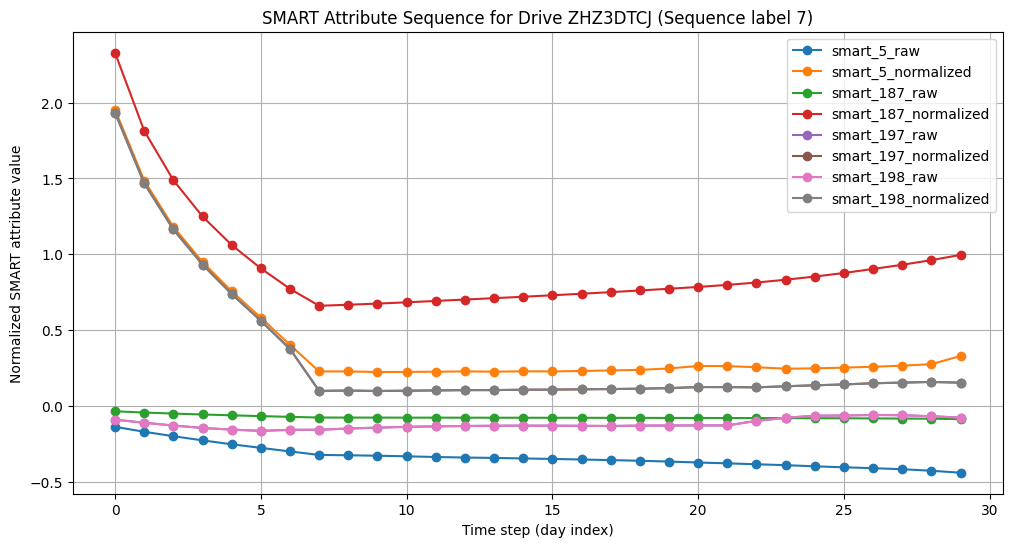

In [7]:
import random
import matplotlib.pyplot as plt

# Choose a random drive from the dataset (using drive_data from the training dataset)
all_drives = list(train_dataset.drive_data.keys())
if not all_drives:
    raise ValueError("No drive data available in the training dataset.")

random_drive = random.choice(all_drives)
print("Randomly selected drive:", random_drive)

# Filter the index mapping for candidate sequences from this drive
drive_candidates = [entry for entry in train_dataset.index_mapping if entry[0] == random_drive]
if not drive_candidates:
    raise ValueError("No candidate sequences found for drive: " + random_drive)

# Choose a random candidate sequence from this drive
selected_candidate = random.choice(drive_candidates)
drive_id, end_date, seq_label = selected_candidate
print(f"Selected candidate from drive {drive_id} ending at {end_date} with sequence label {seq_label}")

# Generate the sequence using the _generate_sequence method (and apply normalization)
sequence = train_dataset._generate_sequence(drive_id, end_date)
if sequence is None:
    raise ValueError("The candidate sequence could not be generated.")

# If a scaler is available, apply it to the SMART attribute portion (skip the first element)
if train_dataset.scaler is not None:
    sequence[1:] = train_dataset.scaler.transform(sequence[1:].reshape(1, -1))[0]

# The first element is model_encoded; the rest are the flattened SMART values.
model_encoded = sequence[0]
flattened_data = sequence[1:]

# Determine number of SMART attributes (e.g., 8 if both raw and normalized are included for 4 attributes)
num_attributes = len(train_dataset.smart_attributes)
# Reshape the flattened SMART data into (sequence_length, num_attributes)
sequence_array = flattened_data.reshape(train_dataset.sequence_length, num_attributes)

# Plot each SMART attribute time series
plt.figure(figsize=(12, 6))
for i in range(num_attributes):
    plt.plot(range(train_dataset.sequence_length), sequence_array[:, i], marker='o', label=train_dataset.smart_attributes[i])

plt.xlabel("Time step (day index)")
plt.ylabel("Normalized SMART attribute value")
plt.title(f"SMART Attribute Sequence for Drive {drive_id} (Sequence label {seq_label})")
plt.legend()
plt.grid(True)
plt.show()
